## Mobile vs Immobile fraction calculation for GEM and HOPS

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from scipy.stats import ttest_ind_from_stats
import seaborn as sns

In [8]:
# Set threshold for immobile stepsize
immobile_stepsize_threshold_nm = 0.25 # in pixels

# Define the two labels for your conditions
labels = ['GEM', 'HOPS']


In [9]:
# CSV file paths for the two conditions
csv_files_1 = filedialog.askopenfilenames(
    title="Select CSV Files for GEM",
    filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
)
csv_files_2 = filedialog.askopenfilenames(
    title="Select CSV Files for HOPS",
    filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
)
csv_files = [csv_files_1, csv_files_2]

In [10]:
columns = [
    "label",
    "replicate_prefix",
    "N, Total",
    "N, Mobile",
    "Static Fraction",
]
lst_rows_of_df = []
num_unique_ids = []

(GEM) vs (HOPS):
p value of mobile fraction: 3.745205528737943e-77 ****
p value of immobile fraction: 3.745205528737943e-77 ****


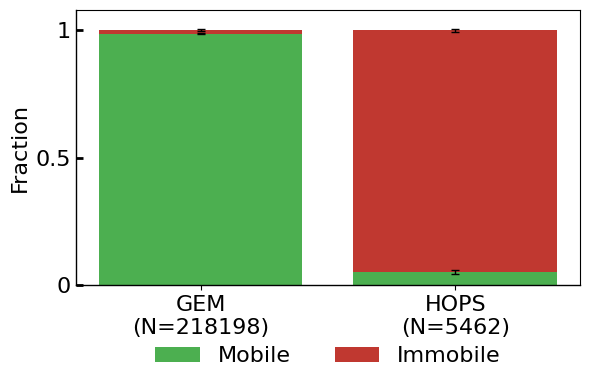

In [12]:
for i in range(2):
    total_ids = 0
    for fname in csv_files[i]:
        df_current = pd.read_csv(fname)
        df_current = df_current.astype({"mean_step_sizes": float})
        N_total = df_current.shape[0]
        
        # Judge if immobile by mean step size
        df_mobile = df_current[df_current["mean_step_sizes"] >= immobile_stepsize_threshold_nm]
        N_mobile = df_mobile.shape[0]
        F_immobile = (N_total - N_mobile) / N_total
        unique_ids = df_current['trackID'].nunique()
        total_ids += unique_ids

        # Save
        lst_rows_of_df.append([labels[i], fname, N_total, N_mobile, F_immobile])
    num_unique_ids.append(total_ids)

data = pd.DataFrame.from_records(lst_rows_of_df, columns=columns)

N_total = data["N, Total"].to_numpy(int)
N_mobile = data["N, Mobile"].to_numpy(int)
N_immobile = N_total - N_mobile

frac_immobile = N_immobile / N_total
frac_mobile = N_mobile / N_total

data["Immobile"] = frac_immobile
data["Mobile"] = frac_mobile

df_mean_error = pd.DataFrame({
    "label": data["label"].unique(),
    "F_immobile_mean": [data[data["label"] == label]["Immobile"].mean() for label in data["label"].unique()],
    "F_immobile_sem": [data[data["label"] == label]["Immobile"].sem() for label in data["label"].unique()],
    "F_immobile_std": [data[data["label"] == label]["Immobile"].std() for label in data["label"].unique()],
    "F_mobile_mean": [data[data["label"] == label]["Mobile"].mean() for label in data["label"].unique()],
    "F_mobile_sem": [data[data["label"] == label]["Mobile"].sem() for label in data["label"].unique()],
    "F_mobile_std": [data[data["label"] == label]["Mobile"].std() for label in data["label"].unique()],
    "nobs": [data[data["label"] == label].shape[0] for label in data["label"].unique()],
}, dtype=object)

def p_annot(p):
    if p > 0.05:
        return "ns"
    elif p > 0.01:
        return "*"
    elif p > 0.001:
        return "**"
    elif p > 0.0001:
        return "***"
    else:
        return "****"

def compare2labels(label1, label2):
    print(f"({label1}) vs ({label2}):")
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1]["F_mobile_mean"].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1]["F_mobile_std"].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2]["F_mobile_mean"].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2]["F_mobile_std"].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of mobile fraction:", pval, p_annot(pval))
    
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1]["F_immobile_mean"].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1]["F_immobile_std"].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2]["F_immobile_mean"].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2]["F_immobile_std"].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of immobile fraction:", pval, p_annot(pval))

compare2labels(labels[0], labels[1])

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
x = np.arange(len(labels))
colors = ["#4CAF50", "#C03830"]  # Green for Mobile, Red for Immobile

df_fractions = df_mean_error[df_mean_error["label"].isin(labels)]
bottom = np.zeros(len(x))
categories = ["F_mobile_mean", "F_immobile_mean"]  # Order ensures Mobile is first

for i in range(len(categories)):
    # Adjust labels and colors to ensure Mobile (green) and Immobile (red)
    ax.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        label="Mobile" if i == 0 else "Immobile",  # Correct labeling
        bottom=bottom,
        color=colors[i],
    )
    bottom += df_fractions[categories[i]]

ax.set_ylim(0, 1.08)
ax.set_ylabel("Fraction", fontsize=16)

# Customize x-tick labels with N values
labels_with_counts = [f"{label}\n(N={count})" for label, count in zip(labels, num_unique_ids)]
ax.set_xticks(x)
ax.set_xticklabels(labels_with_counts, fontsize=16)

ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1], fontsize=16)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
# ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(
    axis="y",
    which="major",
    direction="in",
    left=True,
    length=5,
    width=2,
)
legend = ax.legend(
    ["Mobile", "Immobile"], 
    fontsize=16, 
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.15),  # centered at the bottom
    ncol=2,  # arrange in a single row
    frameon=False
)
legend.get_frame().set_linewidth(0)
fig.tight_layout()
fig.savefig(
    "Fracs_compare_GEM_vs_HOPS.png",
    format="png",
    bbox_inches="tight",
    dpi=600,
)
plt.show()